In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import fastprogress
from fastprogress.fastprogress import master_bar, progress_bar

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.__version__, fastprogress.__version__

('1.4.0', '0.2.3')

In [2]:
epochs = 35
bs = 256
plot = True

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
# sample data
trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform)
# trainset.data = trainset.data[:1500]
trn_loader = torch.utils.data.DataLoader(trainset,
                                          batch_size=bs,
                                          shuffle=True,
                                          num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform)
# testset.data = testset.data[:1500]
val_loader = torch.utils.data.DataLoader(testset,
                                         batch_size=bs,
                                         shuffle=False,
                                         num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


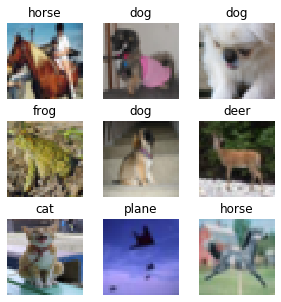

In [5]:
# show images
def show_images(dataset, classes, rows=3, seed=0,save=False, name=0):
    fig = plt.figure(figsize=(5, 5))
    
    np.random.seed(seed)
    index = np.random.permutation(len(dataset))[:rows**2]
    plt.subplots_adjust(wspace=0.1, hspace=0.3)
    
    for i, idx in enumerate(index, 1):
        fig.add_subplot(rows, rows, i)
        plt.axis('off')
        plt.title(f'{classes[trainset.targets[idx]]}')
        plt.imshow(trainset.data[idx])
        
    if save:
        plt.savefig(f'sample_{name}.png')
        
show_images(trainset, classes)

In [6]:
class Conv_Block(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Conv_Block, self).__init__()
        self.conv_block = nn.Sequential(nn.Conv2d(in_dim, out_dim, 3),
                                        nn.ReLU(), nn.BatchNorm2d(out_dim),
                                        nn.MaxPool2d(2, 2))

    def forward(self, x):
        return self.conv_block(x)


class Linear_Block(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Linear_Block, self).__init__()
        self.linear_block = nn.Sequential(nn.Linear(in_dim, out_dim),
                                          nn.ReLU(), nn.BatchNorm1d(out_dim))

    def forward(self, x):
        return self.linear_block(x)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_net = nn.Sequential(Conv_Block(3, 8), 
                                      Conv_Block(8, 16),
                                      Conv_Block(16, 32))

        self.mlp = nn.Sequential(Linear_Block(32 * 2 * 2, 128),
                                 Linear_Block(128, 128), 
                                 nn.Linear(128, 10))

    def forward(self, x):
        x = self.conv_net(x)
        x = nn.AdaptiveAvgPool2d(2)(x)
        x = x.view(-1, 32 * 2 * 2)
        x = self.mlp(x)
        return x

In [7]:
net = Net().to(device)

In [8]:
# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

In [9]:
def train_one_epoch():
    net.train()
    running_loss = 0.0
    acc = 0.0

    trn_tqdm = progress_bar(trn_loader, total=int(len(trn_loader)), parent=mb)
    for i, (imgs, ys) in enumerate(trn_tqdm, 1):
        # to device
        imgs = imgs.to(device)
        ys = ys.to(device)

        # forward and backward
        optimizer.zero_grad()
        preds = net(imgs)
        loss = criterion(preds, ys)
        loss.backward()
        optimizer.step()

        # loss
        history['losses'].append(loss.item())
        running_loss += loss.item() * len(imgs)

        # acc
        _, preds = torch.max(preds, 1)
        acc += (preds == ys).sum().item()

        # set commet on child progressbar
        mb.child.comment = (f'loss={loss.item():.4f}, '
                            f'acc={(preds==ys).sum().item()/len(imgs):.4f}')
        

    return running_loss / len(trainset), acc / len(trainset)


def evaluate_one_epoch():
    net.eval()
    running_loss = 0.0
    acc = 0.0

    val_tqdm = progress_bar(val_loader, total=int(len(val_loader)), parent=mb)
    for i, (imgs, ys) in enumerate(val_tqdm, 1):
        # to device
        imgs = imgs.to(device)
        ys = ys.to(device)

        with torch.no_grad():
            preds = net(imgs)
            loss = criterion(preds, ys)

        # loss
        running_loss += loss.item() * len(imgs)

        # acc
        _, preds = torch.max(preds, 1)
        acc += (preds == ys).sum().item()

        # set commet on child progressbar
        mb.child.comment = (f'val_loss={loss.item():.4f}, ' 
                            f'val_acc={(preds==ys).sum().item()/len(imgs):.4f}')

    return running_loss / len(testset), acc / len(testset)

epoch,train loss,valid loss,train acc,valid acc,time
1,1.734099,1.506289,0.373820,0.462300,0:11
2,1.417091,1.370943,0.494500,0.506100,0:10
3,1.297517,1.302048,0.538080,0.535400,0:10
4,1.217674,1.251176,0.567960,0.552600,0:10
5,1.157376,1.214135,0.592400,0.564400,0:10
6,1.109476,1.195601,0.608140,0.574800,0:10
7,1.069339,1.168256,0.624020,0.587000,0:10
8,1.032325,1.156441,0.635840,0.590500,0:10
9,1.000072,1.143207,0.647240,0.591500,0:10
10,0.972939,1.135387,0.656820,0.602800,0:10


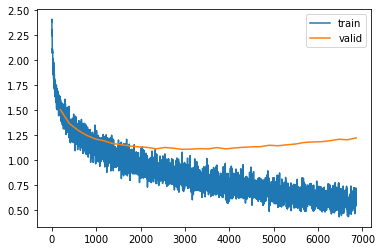

In [10]:
# main
history = {
    'losses': [],
    'trn_losses': [],
    'trn_accs': [],
    'val_losses': [],
    'val_accs': [],
}

mb = master_bar(range(1, epochs + 1))
mb.write(
    ('epoch', 'train loss', 'valid loss', 'train acc', 'valid acc', 'time'),
    table=True)

mb.name = ['train_loss', 'val_loss']
for epoch in mb:

    # train
    start_time = time.time()
    trn_loss, trn_acc = train_one_epoch()
    # record
    history['trn_losses'].append(trn_loss)
    history['trn_accs'].append(trn_acc)

    # evaluate
    val_loss, val_acc = evaluate_one_epoch()
    # record
    history['val_losses'].append(val_loss)
    history['val_accs'].append(val_acc)

    # calculate time
    end_time = time.time()
    m, s = divmod(end_time - start_time, 60)

    # print
    mb.write((f'{epoch}', f'{trn_loss:.6f}', f'{val_loss: .6f}',
              f'{trn_acc:.6f}', f'{val_acc:.6f}', f'{m:.0f}:{s:.0f}'),
             table=True)
    
    # plot
    if plot:
        x = np.arange(len(trn_loader)-1, len(history['losses']), len(trn_loader))
        graphs = [[history['losses']], [x, history['val_losses']]]
        mb.update_graph(graphs)

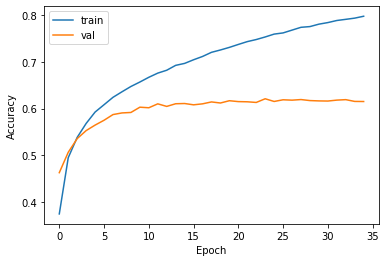

In [11]:
plt.plot(history['trn_accs'], 'C0', label='train')
plt.plot(history['val_accs'], 'C1', label='val')

plt.legend()
# plt.title("Accuracy")
plt.ylabel("Accuracy") 
plt.xlabel("Epoch");

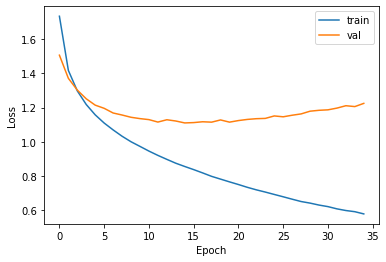

In [12]:
plt.plot(history['trn_losses'], 'C0', label='train')
plt.plot(history['val_losses'], 'C1', label='val')

plt.legend()
# plt.title("Loss")
plt.ylabel("Loss") 
plt.xlabel("Epoch");

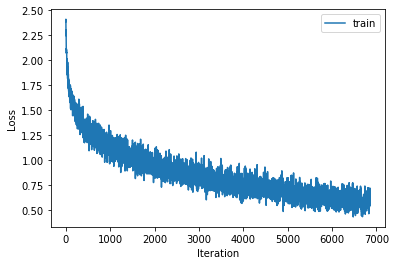

In [13]:
plt.plot(history['losses'], 'C0', label='train');

plt.legend()
plt.ylabel("Loss") 
plt.xlabel("Iteration");

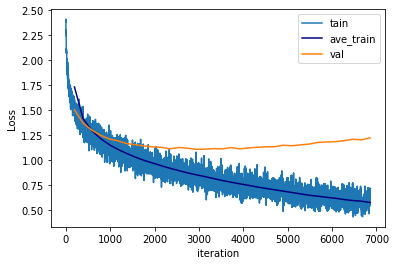

In [14]:
x = np.arange(len(trn_loader)-1, len(history['losses']), len(trn_loader))
plt.plot(history['losses'], 'C0', label='tain')

plt.plot(x, history['trn_losses'], 'navy', label='ave_train')
plt.plot(x, history['val_losses'], 'C1', label='val')

plt.legend()
# plt.title("Loss")
plt.ylabel("Loss") 
plt.xlabel("iteration");